# Notes

**Focus on**:
- Quality of data
- Log your data and calls when using data scraping
- Creativity
- Visualization (explanatory figures), simple is better
- Be critical of your data collection and generating process
    - Bias
    - Missing data
        - Ignore
        - Collect new data
        - Remove or replace missing data
    - Internal and external validity
    - Data collection type (random, survey, big data, other)
- Less focus on the analytical section and more on the collection and presentation

### Reflect on the ethical aspect
- Do you respect privacy? 
- Can single individuals be identified? 
- What are the potential consequences?
- Are there ethical considerations?
    - With respect to individuals? 
    - With respectto firms or organizations?
- Consider the GDPR:
    - Is it anonymous? 
    - Personal data or statistics?
    - Any change of re-identification?

### Logging

- Log your calls, use it to determine success ratio
    - Where did the call fail? Rewrite code.
    - Don't be greedy. time.sleep(0.5) between each call.
- Visualize the log (lecture 10)

We start by importing our data source to Python. The file *tweets.json* is created from [the Trump twitter archive](http://www.trumptwitterarchive.com/archive). We have selected all tweets from the 20th of January 2017 (assumed office) to 21st of August 2019.

**DOCSTRING**

Below we provide our docstring to the data project.
We import the relevant packages, some of which will require installation through either *pip* or *conda*. 

In [99]:
'''
DOCSTRING:

This project analyzes Donald J. Trump's twitter data and presents a visual analysis of key elements.
It makes use of several packages, some of which should be installed via either pip or conda.
Executing the code cells will save files to the relative path of this Jupyter Notebook. 

'''

# Importing packages
import pandas as pd
import scraping_class, time, json
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
% matplotlib inline


We set up our connector to the relevant data source and log our connections in a file called *my_log*. 

We later use the log file to visualize our data connection attempts.

In [31]:
logfile = 'my_log'## name your log file.
connector = scraping_class.Connector(logfile)
data = []
# Fetching data
for i in range(2015,2020):
    url = 'http://www.trumptwitterarchive.com/data/realdonaldtrump/'+str(i)+'.json'
    r, call_id = connector.get(url, 'Tweets')
    json_file = r.json() 
    data += json_file[::-1] # invert list
    time.sleep(0.5) # set sleep timer to prevent unintentional DOS attacks

In [37]:
# Creating and manipulating dataframes
# Main dataframe
df = pd.DataFrame(data)
date = [i[2]+i[1]+i[-1]+'-'+i[3] for i in df['created_at'].str.split(' ')] # slice date
df['datetime'] = date
df['datetime'] = pd.to_datetime(df['datetime'], format='%d%b%Y-%H:%M:%S') # format datetime 
#df = df[(df['datetime'] > '2017-01-20')] # filter by relevant date
df = df.query("is_retweet == False") # drop retweets
df = df.reset_index(drop=True).sort_values(by=['datetime']) # set index to date
df.index = df['datetime']

In [108]:
# Define sentiment analyzer score
def sentiment_analyzer_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
     #print("{:-<40} {}".format(sentence, str(score)))
    return score

def afinn_sentiment_analyzer_scores(sentence):
    afinn = Afinn(language='en')
    score = afinn.score(sentence)
    return score

# Add sentiment to dataframe
df['vader'] = [sentiment_analyzer_scores(tweet)['compound'] for tweet in df['text']]
df['afinn'] = [afinn_sentiment_analyzer_scores(tweet) for tweet in df['text']]
display(df.head())



,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,datetime,keyword,sentiment,vader,afinn
datetime,,,,,,,,,,,,,
2015-01-01 00:00:26,Thu Jan 01 00:00:26 +0000 2015,33,550441381253382144,None,False,12,Twitter for Android,"""@JaayZen: @realDonaldTrump Thanks Donald. Now...",2015-01-01 00:00:26,False,0.7494,0.7494,4.0
2015-01-01 00:02:37,Thu Jan 01 00:02:37 +0000 2015,28,550441927964106753,None,False,9,Twitter for Android,"""@teamconquerca: First time in the""Trump Inter...",2015-01-01 00:02:37,False,0.8711,0.8711,5.0
2015-01-01 00:06:40,Thu Jan 01 00:06:40 +0000 2015,36,550442948375347200,None,False,15,Twitter for Android,"""@AngelaTN777: @gochico @realDonaldTrump: He S...",2015-01-01 00:06:40,False,0.4738,0.4738,2.0
2015-01-01 00:09:01,Thu Jan 01 00:09:01 +0000 2015,18,550443540111962113,None,False,11,Twitter for Android,"""@JaayZen: @grandmiapens He has all the ingred...",2015-01-01 00:09:01,False,0.0000,0.0000,0.0
2015-01-01 00:09:47,Thu Jan 01 00:09:47 +0000 2015,17,550443735054839808,None,False,7,Twitter for Android,"""@MarcAardvark: @realDonaldTrump @ronmeier123 ...",2015-01-01 00:09:47,False,0.6369,0.6369,3.0


In [111]:
print(df['vader'].mean(), df['afinn'].mean())

0.2161994479092093 1.3487373479194356


In [40]:
print('Since', df.index[0], 'Mr. Trump has made', len(df), 'tweets')

keywords = ['tariff','trade war','trade'] #List of keywords in lowercase

results = {} #Dictionary to store results
for key in keywords:
    print('Sum of tweets containing', key, ':', sum(df['text'].str.contains('(?i)'+str(key))))
    results[key]=sum(df['text'].str.contains('(?i)'+str(key))) #Saving the sum of tweets (ignoring case) containing the key

result_count = {} # empty dictionary to store results
for key in keywords:
    count_=0 #resetting the counter
    for i in range(len(df['text'])): # Looping through all the rows of tweets
        if key in df['text'][i].lower(): # Checking for the key in  the i'th tweet (in lowercase)
            count_ += df['text'][i].lower().count(key) # given the key is found we count the number of times it occurs
        result_count[key]=count_ # Store the count for a given key in the dictionary

print(result_count)      

Since 2015-01-01 00:00:26 Mr. Trump has made 19562 tweets
Sum of tweets containing tariff : 152
Sum of tweets containing trade war : 9
Sum of tweets containing trade : 324
{'tariff': 204, 'trade war': 9, 'trade': 376}


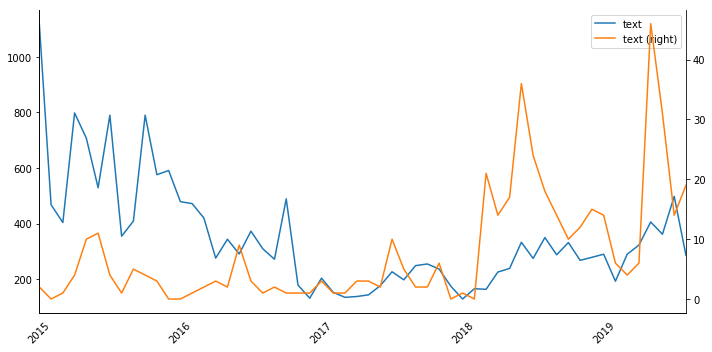

In [41]:
#print(df['text'].resample('M').count())
#print(df['text'].resample('M').count().sum())

# search for keywords while ignoring word case (upper/lower)
df['keyword'] = df['text'].str.contains('(?i)|'.join(keywords)) 
df_filter = df.query("keyword == True") # filter to contain keywords

# Creating figure
ax = plt.gca()
ax = df['text'].resample('M').count().plot(figsize = (10,5), rot = 45, legend=True)
ax1 = plt.gca()
ax1 = df_filter['text'].resample('M').count().plot(figsize = (10,5), rot = 45, secondary_y=True, legend=True)
# Formatting
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax1.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('monthlytweets.png')
plt.show()



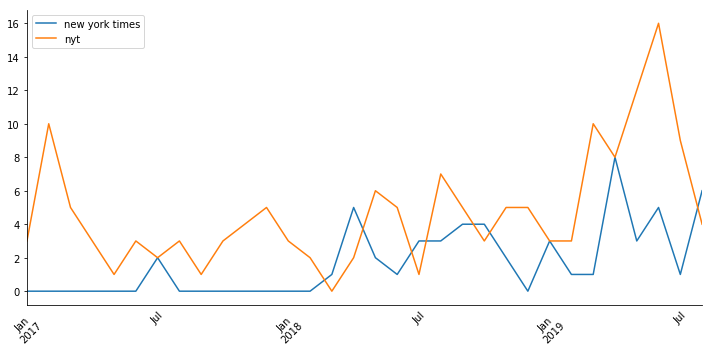

In [26]:
results_time = {}
keywords = ['new york times','nyt']
ax = plt.gca()

# Creating figure
for key in keywords:
    results_time[key] = df['text'].str.contains('(?i)'+str(key)).resample('M').sum()
    ax = df['text'].str.contains('(?i)'+str(key)).resample('M').sum().plot(label=key,
        ax=ax, figsize = (10,5), rot = 45)

# Formatting
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.legend()      
plt.savefig('keywords.png')
plt.show()

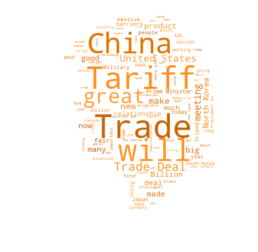

In [295]:
#WORDCLOUD



# function to get custom color for wordcloud
def custom_color(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = 30 # int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(100, 160)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
 
# picture used as shape
trump_mask = np.array(Image.open("trump_mask.jpg")) # read image
trump_mask_T = np.array(Image.open("trump_mask.jpg").transpose(Image.FLIP_LEFT_RIGHT)) # read image transposed

# wordcloud for df_filter
text = " ".join(tweet for tweet in df_filter['text'][df_filter['text'].str.contains(r'^(?:(?!https|co|amp).)*$')])
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask_T, 
                      contour_color ='black',color_func=custom_color).generate(text)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png") # save file

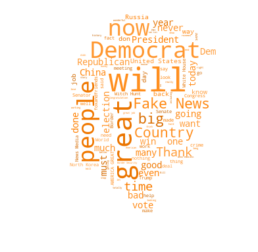

In [296]:
# wordcloud for df
text = " ".join(tweet for tweet in df['text'][df['text'].str.contains(r'^(?:(?!https|co|amp).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_all.png") # save file

In [159]:
# Define functions to display multiple tables
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )
# Fetching trade balance data
url = 'https://www.census.gov/foreign-trade/balance/c5700.html'
r, call_id = connector.get(url,'trade_balance') # connecting and saving connection to log file
dfs = pd.read_html(url) # read the tables
multi_table(dfs[0:4])  # display

,Month,Exports,Imports,Balance
0,January 2019,7134.3,41603.8,-34469.5
1,February 2019,8433.6,33194.4,-24760.8
2,March 2019,10426.5,31175.7,-20749.1
3,April 2019,7896.3,34798.9,-26902.6
4,May 2019,9074.5,39269.1,-30194.6
5,June 2019,9034.7,39002.3,-29967.6
6,TOTAL 2019,52000.0,219044.3,-167044.3
,Month,Exports,Imports,Balance
0,January 2018,9902.6,45765.6,-35863.1
1,February 2018,9759.9,39020.6,-29260.7


In [160]:
# display latex code
for i in range(4):
    print(dfs[i].to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
         Month &  Exports &   Imports &   Balance \\
\midrule
  January 2019 &   7134.3 &   41603.8 &  -34469.5 \\
 February 2019 &   8433.6 &   33194.4 &  -24760.8 \\
    March 2019 &  10426.5 &   31175.7 &  -20749.1 \\
    April 2019 &   7896.3 &   34798.9 &  -26902.6 \\
      May 2019 &   9074.5 &   39269.1 &  -30194.6 \\
     June 2019 &   9034.7 &   39002.3 &  -29967.6 \\
    TOTAL 2019 &  52000.0 &  219044.3 & -167044.3 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
          Month &   Exports &   Imports &   Balance \\
\midrule
   January 2018 &    9902.6 &   45765.6 &  -35863.1 \\
  February 2018 &    9759.9 &   39020.6 &  -29260.7 \\
     March 2018 &   12652.1 &   38327.6 &  -25675.5 \\
     April 2018 &   10503.8 &   38303.9 &  -27800.1 \\
       May 2018 &   10428.2 &   43965.7 &  -33537.5 \\
      June 2018 &   10860.1 &   44612.1 &  -33752.0 \\
      July 2018 &   10134.6 &   47120.6 &  -36986.0 \\
    August 2018 &    9285.9 &

,Month,Exports,Imports,Balance
0,January 2016,8208.9,37126.4,-28917.5
1,February 2016,8080.5,36066.9,-27986.4
2,March 2016,8925.6,29812.3,-20886.8
3,April 2016,8679.7,32920.2,-24240.5
4,May 2016,8542.0,37513.7,-28971.8


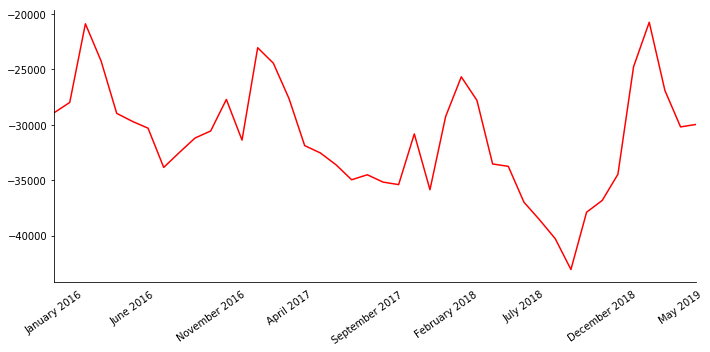

In [220]:
df_trade = pd.concat([dfs[i][:-1] for i in range(4)][::-1]) # removing "total" and concatenating data frames

# Plotting figure
ax = plt.gca()
df_trade.plot(kind='line',x='Month',y='Balance', color='red', ax=ax, figsize = (10,5), rot = 35, legend=False)
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('tradebalance.png')
plt.show()